In [1]:
# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

# General libraries
import time
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import MultipleLocator

# SK-learn libraries for learning.
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB

# SK-learn libraries for evaluation.
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import classification_report

# SK-learn library for importing the newsgroup data.
from sklearn.datasets import fetch_20newsgroups

# SK-learn libraries for feature extraction from text.
from sklearn.feature_extraction.text import *

import nltk

# Set the randomizer seed so results are the same each time.
np.random.seed(0)

data = pd.read_csv(r"..\..\data\covtype.csv")
train_df = pd.read_csv(r"..\..\data\train.csv")
test_df = pd.read_csv(r"..\..\data\test.csv")

### Feature Engineering
# Drop "ID"
train_df = train_df.drop(columns=["Id"])

# Create Labels DF
train_labels_df = train_df[["Cover_Type"]]

# Drop Labels
train_df = train_df.drop(columns=["Cover_Type"])

# Build the np arrays
train_data = train_df.to_numpy()
test_data = test_df.drop(columns=["Id"]).to_numpy()
train_labels = train_labels_df.to_numpy().ravel()

# Shuffle the input
shuffle = np.random.permutation(np.arange(train_data.shape[0]))
train_data, train_labels = train_data[shuffle], train_labels[shuffle]

# Set some variables to hold dev, and training data.
dev_data, dev_labels = train_data[14000:], train_labels[14000:]
train_data, train_labels = train_data[:14000], train_labels[:14000]

## PCA

[0.7218959054455099, 0.9477491367462696, 0.9835319135851278, 0.9946008057018806, 0.9987227195142865, 0.9999996066709803, 0.99999988079987, 0.999999968812523, 0.9999999966860198, 0.9999999999999999]


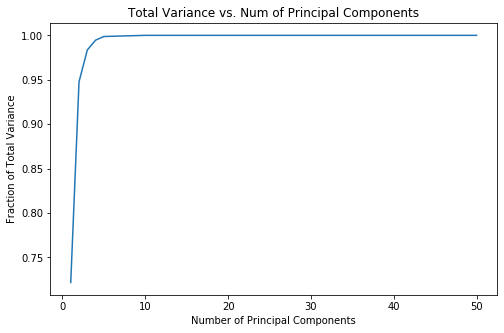

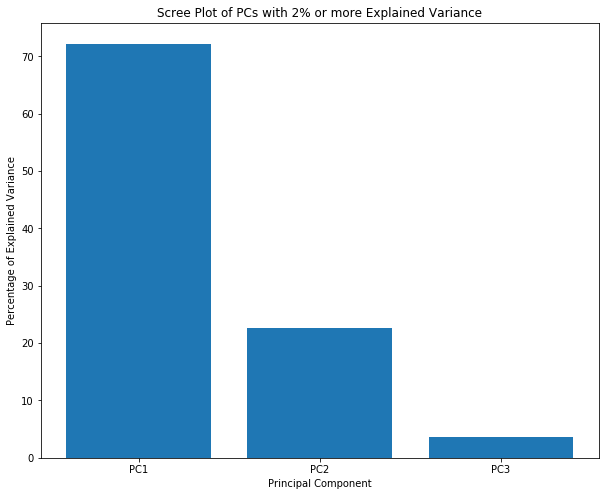

Top 10 features and their loading score influced on PC1:
--------------------------------------------------------
Horizontal_Distance_To_Roadways       0.812699
Horizontal_Distance_To_Fire_Points    0.554671
Elevation                             0.175417
Horizontal_Distance_To_Hydrology      0.032411
Hillshade_3pm                         0.004436
Hillshade_Noon                        0.003504
Aspect                                0.002003
Slope                                -0.001723
Hillshade_9am                         0.000678
Vertical_Distance_To_Hydrology        0.000557
dtype: float64


In [2]:
from sklearn.decomposition import PCA

def do_pca (t_data, n, k_principal_components):
    # Use PCA from sklearn and set number of components to the shape of the train_data feature size
    # Fit to the Train Data and get the variance ratio
    pca = PCA(n_components=n)
    pca.fit(t_data)
    explained_variance_ratio = pca.explained_variance_ratio_

    # Find only the prinicpal_components ratios
    total_variance = []
    for k in k_principal_components:
        total_variance_ratio = sum(explained_variance_ratio[0:k])
        total_variance.append(total_variance_ratio)

    print(total_variance)

    #Plot the total variance vs. number of principal components,
    fig = plt.figure(figsize=(8, 5))
    ax = fig.add_subplot(1, 1, 1)
    plt.plot(k_principal_components,total_variance)
    plt.ylabel("Fraction of Total Variance")
    plt.xlabel("Number of Principal Components")
    plt.title("Total Variance vs. Num of Principal Components")
    plt.show()  


    ##########################
    # Draw a scree plot
    #########################

    #The following code constructs the Scree plot
    per_var = np.round(pca.explained_variance_ratio_* 100, decimals=1)
    per_var = per_var[per_var > 2]
    labels = ['PC' + str(x) for x in range(1, len(per_var)+1)]

    fig = plt.figure(figsize=(10,8))
    plt.bar(x=range(1,len(per_var)+1), height=per_var, tick_label=labels)
    plt.ylabel('Percentage of Explained Variance')
    plt.xlabel('Principal Component')
    plt.title('Scree Plot of PCs with 2% or more Explained Variance')
    plt.show()

    #########################
    # Determine which feature had the biggest influence on PC1
    #########################
    ## first, get the loading scores
    loading_scores = pd.Series(pca.components_[0], index=train_df.columns)
    ## now sort the loading scores based on their magnitude
    sorted_loading_scores = loading_scores.abs().sort_values(ascending=False)
    ## get the names of the top 10 features
    top_10 = sorted_loading_scores[0:10].index.values
    ## print the gene names and their scores (and +/- sign)
    print("Top 10 features and their loading score influced on PC1:")
    print("--------------------------------------------------------")
    print(loading_scores[top_10])

    return

def print_importances(clf):
    importances = np.round(clf.feature_importances_,4)
    features = train_df.columns.to_numpy()
    importances_df = pd.DataFrame({'feature':features,'importance':importances})
    importances_df = importances_df.sort_values('importance',ascending=False)
    importances_df = importances_df[(importances_df.sum(axis=1) != 0)]  
    print(importances_df)

do_pca(train_data, 54, k_principal_components = [1,2,3,4,5,10,20,30,40,50])


### Feature Engineering

In [65]:
data = pd.read_csv(r"..\..\data\covtype.csv")
train_df = pd.read_csv(r"..\..\data\train.csv")
test_df = pd.read_csv(r"..\..\data\test.csv")

### Feature Engineering
# Drop "ID"
train_df = train_df.drop(columns=["Id"])

# Create Labels DF
train_labels_df = train_df[["Cover_Type"]]

# Drop Labels
train_df = train_df.drop(columns=["Cover_Type"])

In [66]:
def convert_soil_types_to_categorical(df):

    df["SoilType"] = 0
    columns = list(df)

    for col_name in columns:
        soil_type = 0
        if col_name[0:9] == 'Soil_Type':
            soil_type = int(col_name[9:])
            df["SoilType"] = df["SoilType"] + df[col_name]*soil_type
            df = df.drop(columns=[col_name])
            
    return df          
            
def convert_wilderness_areas_to_categorical(df):

    df["WildernessArea"] = 0
    columns = list(df)

    for col_name in columns:
        wild_area = 0
        if col_name[0:15] == 'Wilderness_Area':
            wild_area = int(col_name[15:])
            df["WildernessArea"] = df["WildernessArea"] + df[col_name]*wild_area

    for col_name in columns:
        if col_name[0:15] == 'Wilderness_Area':
            df = df.drop(columns=[col_name])

    return df

train_df = convert_soil_types_to_categorical(train_df)
test_df = convert_soil_types_to_categorical(test_df)

train_df = convert_wilderness_areas_to_categorical(train_df)
test_df = convert_wilderness_areas_to_categorical(test_df)

train_df.to_csv("soil_wild_convert_train.csv", index = False)
test_df.to_csv("soil_wild_convert_test.csv", index = False)

print("Converted soil types and wilderness areas")

Converted soil types and wilderness areas


In [67]:
train_df = pd.read_csv(r"soil_wild_convert_train.csv")
test_df = pd.read_csv(r"soil_wild_convert_test.csv")

train_df['Average_Hillshade'] = abs((train_df['Hillshade_9am']+train_df['Hillshade_Noon']+train_df['Hillshade_3pm'])/3)
test_df['Average_Hillshade'] = abs((test_df['Hillshade_9am']+test_df['Hillshade_Noon']+test_df['Hillshade_3pm'])/3)

train_df = train_df.drop(columns=["Hillshade_9am"])
train_df = train_df.drop(columns=["Hillshade_Noon"])
train_df = train_df.drop(columns=["Hillshade_3pm"])
test_df = test_df.drop(columns=["Hillshade_9am"])
test_df = test_df.drop(columns=["Hillshade_Noon"])
test_df = test_df.drop(columns=["Hillshade_3pm"])

train_df.to_csv("hillshade_avg_convert_train.csv", index = False)
test_df.to_csv("hillshade_avg_convert_test.csv", index = False)

print("Converted Hillshade to average")

Converted Hillshade to average


In [71]:
train_df = pd.read_csv(r"hillshade_avg_convert_train.csv")
test_df = pd.read_csv(r"hillshade_avg_convert_test.csv")

train_df['Total_Distance_to_Hydrology'] = (train_df['Horizontal_Distance_To_Hydrology']**2 + 
                                           train_df['Vertical_Distance_To_Hydrology']**2)**0.5
test_df['Total_Distance_to_Hydrology'] = (test_df['Horizontal_Distance_To_Hydrology']**2 + 
                                          test_df['Vertical_Distance_To_Hydrology']**2)**0.5

train_df = train_df.drop(columns=["Horizontal_Distance_To_Hydrology"])
train_df = train_df.drop(columns=["Vertical_Distance_To_Hydrology"])
test_df = test_df.drop(columns=["Horizontal_Distance_To_Hydrology"])
test_df = test_df.drop(columns=["Vertical_Distance_To_Hydrology"])

train_df.to_csv("total_distance_convert_train.csv", index = False)
test_df.to_csv("total_distance_convert_test.csv", index = False)

print("Converted Distance to Hydrology")

Converted Distance to Hydrology


In [69]:
train_df = pd.read_csv(r"total_distance_convert_train.csv")
test_df = pd.read_csv(r"total_distance_convert_test.csv")

if 'Total_Distance_to_Hydrology' in train_df:
    train_df['Total_Distance_to_Hydrology'] = np.log(train_df['Total_Distance_to_Hydrology']+1)
    
if 'Total_Distance_to_Hydrology' in train_df:
    test_df['Total_Distance_to_Hydrology'] = np.log(test_df['Total_Distance_to_Hydrology']+1)
    
train_df['Horizontal_Distance_To_Roadways'] = np.log(train_df['Horizontal_Distance_To_Roadways']+1)
test_df['Horizontal_Distance_To_Roadways'] = np.log(test_df['Horizontal_Distance_To_Roadways']+1)
train_df['Horizontal_Distance_To_Fire_Points'] = np.log(train_df['Horizontal_Distance_To_Fire_Points']+1)
test_df['Horizontal_Distance_To_Fire_Points'] = np.log(test_df['Horizontal_Distance_To_Fire_Points']+1)

train_df.to_csv("log_transform_train.csv", index = False)
test_df.to_csv("log_transform_test.csv", index = False)

print("Completed Log Transform for Distances")

Completed Log Transform for Distances


In [72]:
train_df

,Elevation,Aspect,Slope,Horizontal_Distance_To_Roadways,Horizontal_Distance_To_Fire_Points,SoilType,WildernessArea,Average_Hillshade,Total_Distance_to_Hydrology
0,2596,51,3,510,6279,29,1,200.333333,258.000000
1,2590,56,2,390,6225,29,1,202.000000,212.084889
2,2804,139,9,3180,6121,12,1,202.333333,275.769832
3,2785,155,18,3090,6211,30,1,199.333333,269.235956
4,2595,45,2,391,6172,29,1,201.333333,153.003268
...,...,...,...,...,...,...,...,...,...
15115,2607,243,23,660,1282,4,3,211.666667,258.094944
15116,2603,121,19,618,1325,4,3,187.000000,662.354890
15117,2492,134,25,335,1187,4,3,184.333333,383.293621
15118,2487,167,28,242,932,4,3,195.000000,240.260276


In [73]:
# Build the np arrays
train_data = train_df.to_numpy()
test_data = test_df.drop(columns=["Id"]).to_numpy()
train_labels = train_labels_df.to_numpy().ravel()

# Shuffle the input
shuffle = np.random.permutation(np.arange(train_data.shape[0]))
train_data, train_labels = train_data[shuffle], train_labels[shuffle]

# Set some variables to hold dev, and training data.
dev_data, dev_labels = train_data[14000:], train_labels[14000:]
train_data, train_labels = train_data[:14000], train_labels[:14000]

There are  9 featueres.
[0.7241808684621795, 0.9487700982762255, 0.9848730590243381, 0.9961647170703737, 0.9998913994731461, 0.9999767035627801, 0.9999920885438577, 0.9999998053081026]


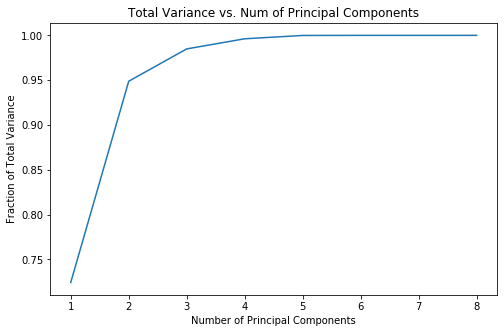

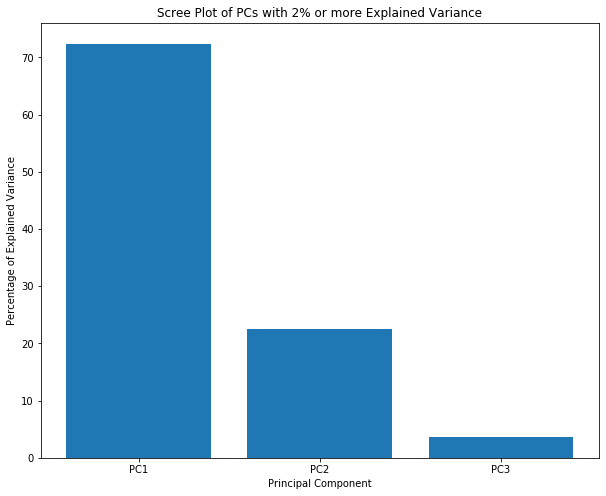

Top 10 features and their loading score influced on PC1:
--------------------------------------------------------
Horizontal_Distance_To_Roadways       0.811945
Horizontal_Distance_To_Fire_Points    0.556285
Elevation                             0.174140
Total_Distance_to_Hydrology           0.030579
SoilType                              0.004281
Average_Hillshade                     0.002829
Aspect                                0.001826
Slope                                -0.001699
WildernessArea                       -0.000408
dtype: float64


In [75]:
num_features = train_df.shape[1]
print("There are ", num_features, "featueres.")
do_pca(train_data, num_features, k_principal_components = [1,2,3,4,5,6,7,8])#,10,20,30,40,50])  

In [76]:
### Warning - this runs VERY slow with n_estimators at 1000
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import plot_confusion_matrix
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score

ex = ExtraTreesClassifier(random_state=0, n_estimators = 1000) 
ex.fit(train_data, train_labels)
extra_trees_score = ex.score(dev_data, dev_labels)
print("Extra Trees Score: ", extra_trees_score)

print("Random Forest 10-Fold Cross Validation Scores: ")
extra_trees_cv_score = cross_val_score(ex, dev_data, dev_labels, cv = 10)
print(extra_trees_cv_score)
print("Mean: ", extra_trees_cv_score.mean())

#### Baseline:
# Extra Trees Score:  0.86875
# Random Forest 10-Fold Cross Validation Scores: 
# [0.71428571 0.72321429 0.70535714 0.80357143 0.76785714 0.69642857
#  0.69642857 0.71428571 0.73214286 0.73214286]
# Mean:  0.7285714285714284 (Kaggle 0.75287)

### Turned Wilderness and SoilType into a category:
# Extra Trees Score:  0.875
# Random Forest 10-Fold Cross Validation Scores: 
# [0.75892857 0.75       0.73214286 0.80357143 0.75892857 0.75
#  0.70535714 0.70535714 0.72321429 0.76785714]
# Mean:  0.7455357142857142  (Kaggle 0.76396)

## Above + Calculating "Average Hillshade"
# Extra Trees Score:  0.8955357142857143
# Random Forest 10-Fold Cross Validation Scores: 
# [0.75       0.82142857 0.75892857 0.74107143 0.78571429 0.71428571
#  0.75892857 0.77678571 0.76785714 0.8125    ]
# Mean:  0.76875 (Kaggle 0.78105)

## Above + "Total Distance to Hydrology"
# Extra Trees Score:  0.8964285714285715
# Random Forest 10-Fold Cross Validation Scores: 
# [0.77678571 0.75892857 0.80357143 0.73214286 0.75       0.72321429
#  0.8125     0.77678571 0.77678571 0.78571429]
# Mean:  0.7696428571428571 (Kaggle 0.78188)

## Above + Log transforming Distances
# Extra Trees Score:  0.8785714285714286
# Random Forest 10-Fold Cross Validation Scores: 
# [0.78571429 0.78571429 0.73214286 0.66964286 0.73214286 0.77678571
#  0.73214286 0.74107143 0.75       0.80357143]
# Mean:  0.7508928571428571 (Kaggle 0.76997)

print_importances(ex)

# ex_predictions = ex.predict(test_data)
# predictions_ex = pd.DataFrame(data = ex_predictions, index = test_df.loc[:, "Id"], columns = ["Cover_Type"])
# predictions_ex.to_csv("ex_predictions.csv")
# print("Wrote Predictions File.")

Extra Trees Score:  0.8991071428571429
Random Forest 10-Fold Cross Validation Scores: 
[0.73214286 0.75       0.74107143 0.6875     0.72321429 0.74107143
 0.78571429 0.74107143 0.8125     0.76785714]
Mean:  0.7482142857142857
                              feature  importance
0                           Elevation      0.2425
5                            SoilType      0.2004
3     Horizontal_Distance_To_Roadways      0.1053
4  Horizontal_Distance_To_Fire_Points      0.0904
6                      WildernessArea      0.0891
8         Total_Distance_to_Hydrology      0.0839
1                              Aspect      0.0789
7                   Average_Hillshade      0.0557
2                               Slope      0.0537
